In [1]:
import sys
sys.path.append('./..') 

In [3]:
import gudhi as gd
import networkx as nx

def compute_average_filtration(G):
    """
    Compute average filtration values for edges of a temporal graph using node timestamps.

    Input:
    - G: networkx.Graph
         Each NODE has a 'timestamp' attribute.
    
    Output:
    - favg: dict mapping edge tuples (u,v) to average filtration value (float)
    """

    def normalize_edge(e):
        return tuple(sorted(e))

    Se = {normalize_edge(e): 0 for e in G.edges()}
    visited = {v: False for v in G.nodes()}
    favg = {}

    temporal_degree = {v: G.degree(v) for v in G.nodes()}

    for v in G.nodes():
        Ev = list(G.edges(v))
        stack = Ev.copy()

        while stack:
            e = stack.pop()
            e_norm = normalize_edge(e)
            u1, u2 = e_norm
            t = min(G.nodes[u1]['timestamp'], G.nodes[u2]['timestamp'])

            for e_prime in stack:
                e_prime_norm = normalize_edge(e_prime)
                v1, v2 = e_prime_norm
                t_prime = min(G.nodes[v1]['timestamp'], G.nodes[v2]['timestamp'])

                delta = abs(t - t_prime)

                Se[e_norm] += delta
                Se[e_prime_norm] += delta

            u = e[1] if e[0] == v else e[0]
            if visited[u]:
                favg[e_norm] = Se[e_norm] / (temporal_degree[v] + temporal_degree[u])

        visited[v] = True

    for e in G.edges():
        e_norm = normalize_edge(e)
        if e_norm not in favg:
            u, v = e_norm
            favg[e_norm] = Se[e_norm] / (temporal_degree[u] + temporal_degree[v])

    return favg



def build_simplex_tree_from_graph(G, favg, max_dim=3):
    """
    Build a GUDHI simplex tree from a graph G using average filtration values for edges.

    Parameters:
    - G: networkx.Graph
    - favg: dict mapping edges (u,v) to filtration values (floats)
    - max_dim: int, max simplex dimension (3 for up to tetrahedra)
    
    Returns:
    - st: gudhi.SimplexTree object with filtration
    """
    st = gd.SimplexTree()
    node_to_id = {node: i for i, node in enumerate(G.nodes())}
    
    for node, idx in node_to_id.items():
        incident_edges = list(G.edges(node))
        if incident_edges:
            filts = []
            for u,v in incident_edges:
                edge_norm = (min(u,v), max(u,v))
                filt_val = favg.get(edge_norm, float('inf'))
                filts.append(filt_val)
            vertex_filt = min(filts) if filts else 0.0
            if vertex_filt == float('inf'):
                vertex_filt = 0.0
        else:
            vertex_filt = 0.0  
            
        st.insert([idx], filtration=vertex_filt)
    
    for u, v in G.edges():
        edge_norm = (min(u, v), max(u, v))
        idx_u, idx_v = node_to_id[u], node_to_id[v]
        filt = favg.get(edge_norm, 0.0)
        st.insert([idx_u, idx_v], filtration=filt)
    
    if max_dim >= 2:
        for clique in nx.enumerate_all_cliques(G):
            if len(clique) >= 3 and len(clique) <= max_dim + 1:
                simplex = [node_to_id[n] for n in clique]
                max_filt = 0.0
                for i in range(len(simplex)):
                    for j in range(i + 1, len(simplex)):
                        edge_nodes = (clique[i], clique[j])
                        edge_norm = (min(edge_nodes), max(edge_nodes))
                        edge_filt = favg.get(edge_norm, 0.0)
                        if edge_filt > max_filt:
                            max_filt = edge_filt
                st.insert(simplex, filtration=max_filt)
    
    st.initialize_filtration()
    return st

In [4]:
import pickle
import os

folder = '../collection/graphs/networkx/concrete'
filename = "graphs_concrete.pkl"
filepath = os.path.join(folder, filename)

with open(filepath, 'rb') as f:
    graphs_concrete = pickle.load(f)
print(f"Loaded {len(graphs_concrete)} graphs from {filepath}")

folder = '../collection/graphs/networkx/dirt'
filename = "graphs_dirt.pkl"
filepath = os.path.join(folder, filename)

with open(filepath, 'rb') as f:
    graphs_dirt = pickle.load(f)
print(f"Loaded {len(graphs_dirt)} graphs from {filepath}")

folder = '../collection/graphs/networkx/rocky'
filename = "graphs_rocky.pkl"
filepath = os.path.join(folder, filename)

with open(filepath, 'rb') as f:
    graphs_rocky = pickle.load(f)
print(f"Loaded {len(graphs_rocky)} graphs from {filepath}")


Loaded 337 graphs from ../collection/graphs/networkx/concrete/graphs_concrete.pkl
Loaded 337 graphs from ../collection/graphs/networkx/dirt/graphs_dirt.pkl
Loaded 337 graphs from ../collection/graphs/networkx/rocky/graphs_rocky.pkl


Number of graphs - Dirt: 337, Concrete: 337, Rocky: 337


/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_52566/1324983540.py:112: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  st.initialize_filtration()


Unique values in B0: [0.000e+00 1.000e-04 2.000e-04 3.000e-04 4.000e-04 5.000e-04 6.000e-04
 7.000e-04 8.000e-04 9.000e-04 1.000e-03 1.100e-03 1.200e-03 1.300e-03
 1.400e-03 1.500e-03 1.600e-03 1.700e-03 1.800e-03 1.900e-03 2.000e-03
 2.100e-03 2.200e-03 2.400e-03 2.700e-03 2.900e-03 3.000e-03 3.300e-03
 3.400e-03 6.600e-03 6.800e-03 6.900e-03 7.200e-03 7.300e-03 7.500e-03
 7.800e-03 1.970e-02 9.983e-01 1.000e+00]
Unique values in B1: [0.000e+00 1.000e-04 2.000e-04 3.000e-04 4.000e-04 5.000e-04 6.000e-04
 7.000e-04 8.000e-04 9.000e-04 1.000e-03 1.100e-03 1.200e-03 1.300e-03
 1.400e-03 1.500e-03 1.600e-03 1.700e-03 1.800e-03 1.900e-03 1.220e-02
 1.240e-02 1.250e-02 1.440e-02 1.470e-02 1.480e-02 1.490e-02 1.500e-02
 9.990e-01 9.991e-01 9.992e-01 9.993e-01 9.994e-01 1.000e+00]


/Users/arianamondiri/anaconda3/envs/tda_ml/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/arianamondiri/anaconda3/envs/tda_ml/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


pos_h0 shape: (1011, 2)
pos_h1 shape: (1011, 2)


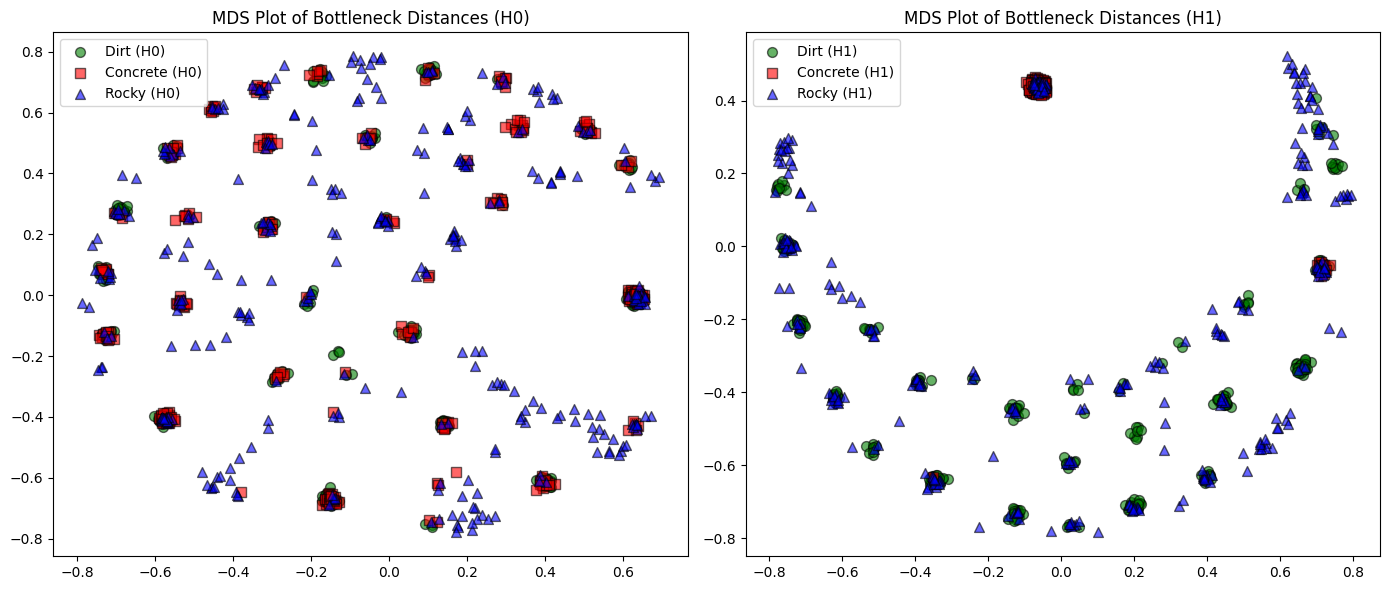

In [5]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

all_graphs = graphs_dirt + graphs_concrete + graphs_rocky
num_dirt = len(graphs_dirt)
num_concrete = len(graphs_concrete)
num_rocky = len(graphs_rocky)
total_graphs = len(all_graphs)

print(f"Number of graphs - Dirt: {num_dirt}, Concrete: {num_concrete}, Rocky: {num_rocky}")

persistence_list0 = []
persistence_list1 = []

for idx, g in enumerate(all_graphs):
    filtration = compute_average_filtration(g)  
    simplex_tree = build_simplex_tree_from_graph(g, filtration, max_dim=2)  
    simplex_tree.persistence()

    pd0 = simplex_tree.persistence_intervals_in_dimension(0)
    pd1 = simplex_tree.persistence_intervals_in_dimension(1)

    persistence_list0.append(pd0)
    persistence_list1.append(pd1)

def compute_bottleneck_distance_matrix(persistence_list):
    l = len(persistence_list)
    D = np.full((l, l), np.inf)
    for i in range(l):
        for j in range(i):
            dist = gd.bottleneck_distance(persistence_list[i], persistence_list[j])
            D[i, j] = dist
            D[j, i] = dist
    np.fill_diagonal(D, 0)
    return D

B0 = compute_bottleneck_distance_matrix(persistence_list0)
B1 = compute_bottleneck_distance_matrix(persistence_list1)

#Replace infs with fixed large values ---
fixed_inf_replacement_B0 = np.max(B0[np.isfinite(B0)]) + 1.0
fixed_inf_replacement_B1 = np.max(B1[np.isfinite(B1)]) + 1.0

B0[np.isinf(B0)] = fixed_inf_replacement_B0
B1[np.isinf(B1)] = fixed_inf_replacement_B1

#  Normalize distances ---
def normalize_distances(D):
    max_val = np.max(D[np.isfinite(D)])
    return D / max_val if max_val != 0 else D

B0 = normalize_distances(B0)
B1 = normalize_distances(B1)


print("Unique values in B0:", np.unique(np.round(B0, decimals=4)))
print("Unique values in B1:", np.unique(np.round(B1, decimals=4)))

# MDS embedding ---
def compute_mds_embedding_from_distance_matrix(D):
    D = D.copy()
    np.fill_diagonal(D, 0)
    mds = manifold.MDS(
        n_components=2,
        max_iter=3000,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=42
    )
    return mds.fit_transform(D)

pos_h0 = compute_mds_embedding_from_distance_matrix(B0)
pos_h1 = compute_mds_embedding_from_distance_matrix(B1)

print(f"pos_h0 shape: {pos_h0.shape}")
print(f"pos_h1 shape: {pos_h1.shape}")

#  Add jitter to embeddings ---
def add_jitter(pos, scale=1e-2):
    jitter = np.random.normal(0, scale, pos.shape)
    return pos + jitter

jitter_scale = 0.01
pos_h0_jittered = add_jitter(pos_h0, scale=jitter_scale)
pos_h1_jittered = add_jitter(pos_h1, scale=jitter_scale)

#  Plot embeddings with jitter ---
plt.figure(figsize=(14, 6))

# H0 plot
plt.subplot(1, 2, 1)
plt.scatter(pos_h0_jittered[:num_dirt, 0], pos_h0_jittered[:num_dirt, 1],
            color='green', label='Dirt (H0)', alpha=0.6, edgecolors='k', s=50, marker='o')
plt.scatter(pos_h0_jittered[num_dirt:num_dirt+num_concrete, 0], pos_h0_jittered[num_dirt:num_dirt+num_concrete, 1],
            color='red', label='Concrete (H0)', alpha=0.6, edgecolors='k', s=50, marker='s')
plt.scatter(pos_h0_jittered[num_dirt+num_concrete:, 0], pos_h0_jittered[num_dirt+num_concrete:, 1],
            color='blue', label='Rocky (H0)', alpha=0.6, edgecolors='k', s=50, marker='^')
plt.title('MDS Plot of Bottleneck Distances (H0)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(pos_h1_jittered[:num_dirt, 0], pos_h1_jittered[:num_dirt, 1],
            color='green', label='Dirt (H1)', alpha=0.6, edgecolors='k', s=50, marker='o')
plt.scatter(pos_h1_jittered[num_dirt:num_dirt+num_concrete, 0], pos_h1_jittered[num_dirt:num_dirt+num_concrete, 1],
            color='red', label='Concrete (H1)', alpha=0.6, edgecolors='k', s=50, marker='s')
plt.scatter(pos_h1_jittered[num_dirt+num_concrete:, 0], pos_h1_jittered[num_dirt+num_concrete:, 1],
            color='blue', label='Rocky (H1)', alpha=0.6, edgecolors='k', s=50, marker='^')
plt.title('MDS Plot of Bottleneck Distances (H1)')
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_52566/2818151109.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pe_dirt_0[:,0], pe_concrete_0[:,0], pe_rocky_0[:,0]], labels=['Dirt H0', 'Concrete H0', 'Rocky H0'])
/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_52566/2818151109.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pe_dirt_1[:,0], pe_concrete_1[:,0], pe_rocky_1[:,0]], labels=['Dirt H1', 'Concrete H1', 'Rocky H1'])


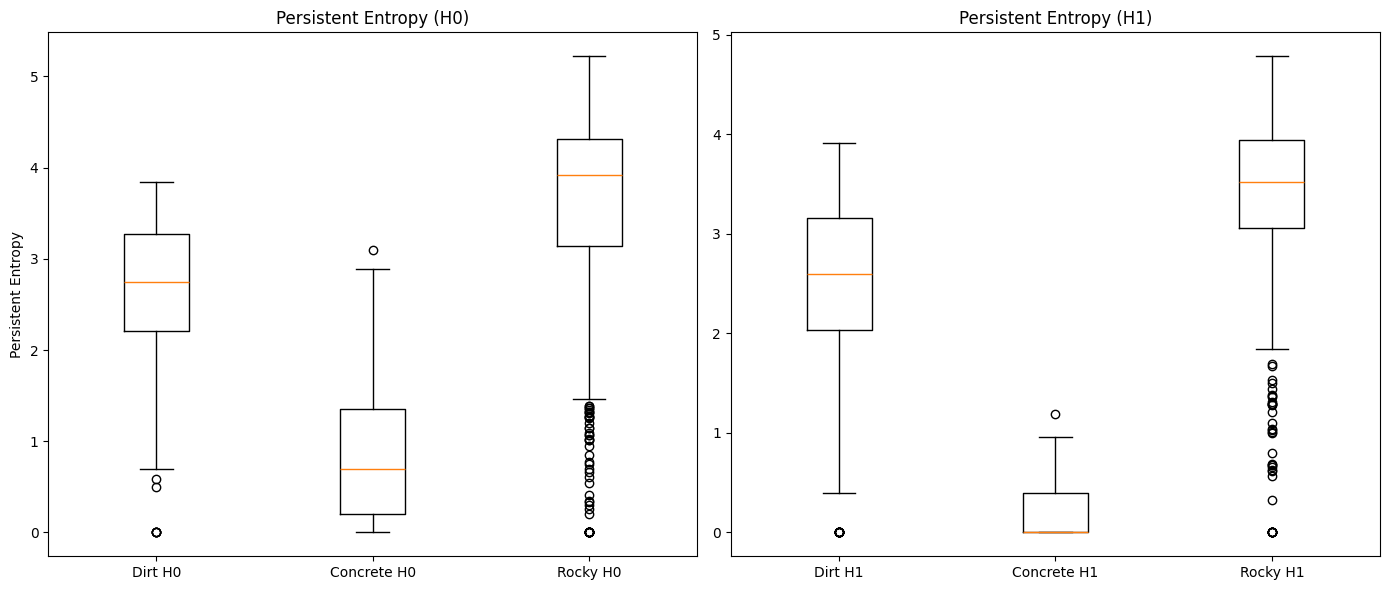

Dirt H0 PE: mean=2.661, std=0.769, n=337
Concrete H0 PE: mean=0.860, std=0.731, n=317
Rocky H0 PE: mean=3.417, std=1.416, n=337
Dirt H1 PE: mean=2.456, std=0.935, n=331
Concrete H1 PE: mean=0.192, std=0.295, n=55
Rocky H1 PE: mean=3.261, std=1.118, n=316


In [ ]:
import numpy as np
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt

# --- Split persistence diagrams by class ---
dirt_diags_0 = persistence_list0[:num_dirt]
concrete_diags_0 = persistence_list0[num_dirt:num_dirt+num_concrete]
rocky_diags_0 = persistence_list0[num_dirt+num_concrete:]

dirt_diags_1 = persistence_list1[:num_dirt]
concrete_diags_1 = persistence_list1[num_dirt:num_dirt+num_concrete]
rocky_diags_1 = persistence_list1[num_dirt+num_concrete:]


remove_infinity = lambda barcode: np.array([bar for bar in barcode if bar[1] != np.inf])

dirt_diags_0_finite = list(map(remove_infinity, dirt_diags_0))
concrete_diags_0_finite = list(map(remove_infinity, concrete_diags_0))
rocky_diags_0_finite = list(map(remove_infinity, rocky_diags_0))

dirt_diags_1_finite = list(map(remove_infinity, dirt_diags_1))
concrete_diags_1_finite = list(map(remove_infinity, concrete_diags_1))
rocky_diags_1_finite = list(map(remove_infinity, rocky_diags_1))


def fix_diagram_shape(diagram):
    arr = np.array(diagram)
    if arr.size == 0:
        # Empty diagram, shape (0, 2)
        return arr.reshape(0, 2)
    if arr.ndim == 1:
        # Single bar, reshape to (1, 2)
        arr = arr.reshape(1, 2)
    return arr

dirt_diags_0_finite = [fix_diagram_shape(d) for d in dirt_diags_0_finite]
concrete_diags_0_finite = [fix_diagram_shape(d) for d in concrete_diags_0_finite]
rocky_diags_0_finite = [fix_diagram_shape(d) for d in rocky_diags_0_finite]

dirt_diags_1_finite = [fix_diagram_shape(d) for d in dirt_diags_1_finite]
concrete_diags_1_finite = [fix_diagram_shape(d) for d in concrete_diags_1_finite]
rocky_diags_1_finite = [fix_diagram_shape(d) for d in rocky_diags_1_finite]


#Filter out empty diagrams (0 bars) ---
def filter_nonempty(barcodes):
    return [b for b in barcodes if b.shape[0] > 0]

dirt_diags_0_finite = filter_nonempty(dirt_diags_0_finite)
concrete_diags_0_finite = filter_nonempty(concrete_diags_0_finite)
rocky_diags_0_finite = filter_nonempty(rocky_diags_0_finite)

dirt_diags_1_finite = filter_nonempty(dirt_diags_1_finite)
concrete_diags_1_finite = filter_nonempty(concrete_diags_1_finite)
rocky_diags_1_finite = filter_nonempty(rocky_diags_1_finite)


#Compute Persistent Entropy (PE) ---

PE = gd.representations.Entropy()

pe_dirt_0 = PE.fit_transform(dirt_diags_0_finite)
pe_concrete_0 = PE.fit_transform(concrete_diags_0_finite)
pe_rocky_0 = PE.fit_transform(rocky_diags_0_finite)

pe_dirt_1 = PE.fit_transform(dirt_diags_1_finite)
pe_concrete_1 = PE.fit_transform(concrete_diags_1_finite)
pe_rocky_1 = PE.fit_transform(rocky_diags_1_finite)


#Plot Persistent Entropy boxplots ---

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.boxplot([pe_dirt_0[:,0], pe_concrete_0[:,0], pe_rocky_0[:,0]], labels=['Dirt H0', 'Concrete H0', 'Rocky H0'])
plt.title('Persistent Entropy (H0)')
plt.ylabel('Persistent Entropy')

plt.subplot(1, 2, 2)
plt.boxplot([pe_dirt_1[:,0], pe_concrete_1[:,0], pe_rocky_1[:,0]], labels=['Dirt H1', 'Concrete H1', 'Rocky H1'])
plt.title('Persistent Entropy (H1)')

plt.tight_layout()
plt.show()


def print_summary(name, data):
    print(f"{name}: mean={np.mean(data):.3f}, std={np.std(data):.3f}, n={len(data)}")

print_summary("Dirt H0 PE", pe_dirt_0)
print_summary("Concrete H0 PE", pe_concrete_0)
print_summary("Rocky H0 PE", pe_rocky_0)

print_summary("Dirt H1 PE", pe_dirt_1)
print_summary("Concrete H1 PE", pe_concrete_1)
print_summary("Rocky H1 PE", pe_rocky_1)




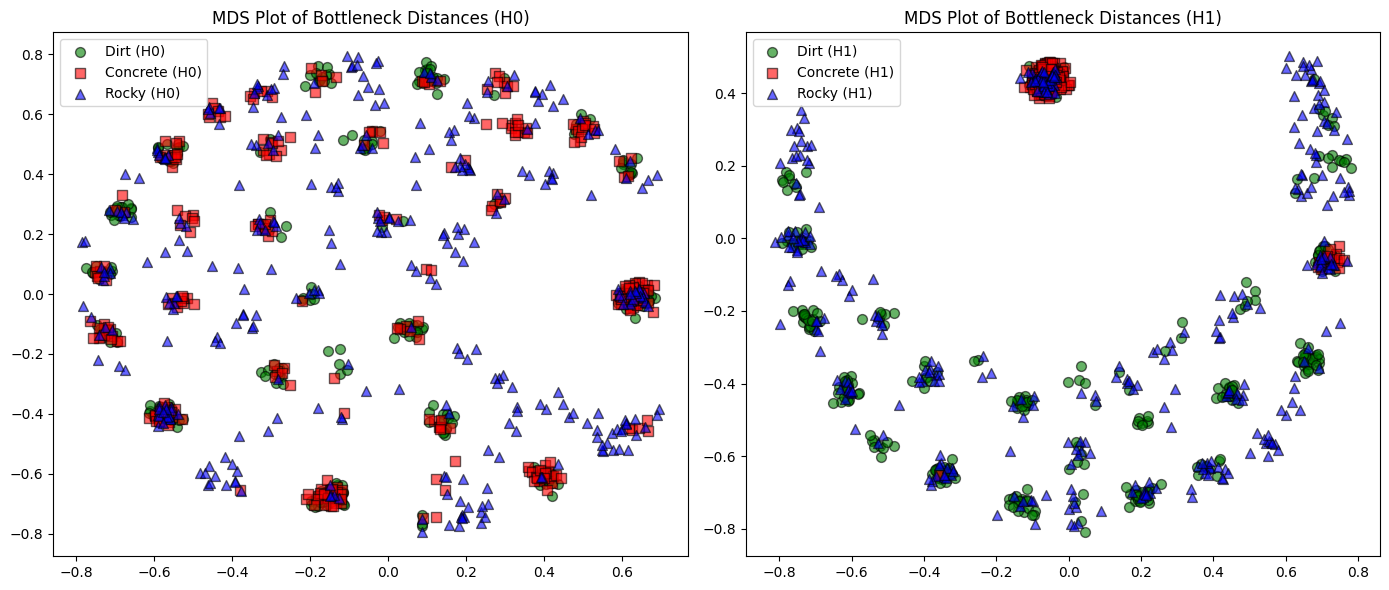

In [ ]:
# Add some small random noise for jitter to avoid overplotting
jitter_strength = 0.02
pos_h0_jittered = pos_h0 + jitter_strength * np.random.randn(*pos_h0.shape)
pos_h1_jittered = pos_h1 + jitter_strength * np.random.randn(*pos_h1.shape)

plt.figure(figsize=(14, 6))

# H0 plot
plt.subplot(1, 2, 1)
plt.scatter(pos_h0_jittered[:num_dirt, 0], pos_h0_jittered[:num_dirt, 1],
            color='green', label='Dirt (H0)', alpha=0.6, edgecolors='k', s=50, marker='o')
plt.scatter(pos_h0_jittered[num_dirt:num_dirt+num_concrete, 0], pos_h0_jittered[num_dirt:num_dirt+num_concrete, 1],
            color='red', label='Concrete (H0)', alpha=0.6, edgecolors='k', s=50, marker='s')
plt.scatter(pos_h0_jittered[num_dirt+num_concrete:, 0], pos_h0_jittered[num_dirt+num_concrete:, 1],
            color='blue', label='Rocky (H0)', alpha=0.6, edgecolors='k', s=50, marker='^')
plt.title('MDS Plot of Bottleneck Distances (H0)')
plt.legend()

# H1 plot
plt.subplot(1, 2, 2)
plt.scatter(pos_h1_jittered[:num_dirt, 0], pos_h1_jittered[:num_dirt, 1],
            color='green', label='Dirt (H1)', alpha=0.6, edgecolors='k', s=50, marker='o')
plt.scatter(pos_h1_jittered[num_dirt:num_dirt+num_concrete, 0], pos_h1_jittered[num_dirt:num_dirt+num_concrete, 1],
            color='red', label='Concrete (H1)', alpha=0.6, edgecolors='k', s=50, marker='s')
plt.scatter(pos_h1_jittered[num_dirt+num_concrete:, 0], pos_h1_jittered[num_dirt+num_concrete:, 1],
            color='blue', label='Rocky (H1)', alpha=0.6, edgecolors='k', s=50, marker='^')
plt.title('MDS Plot of Bottleneck Distances (H1)')
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_52566/3007585846.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot([pe_dirt_0[:, 0], pe_concrete_0[:, 0], pe_rocky_0[:, 0]], labels=['Dirt H0', 'Concrete H0', 'Rocky H0'])
/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_52566/3007585846.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot([pe_dirt_1[:, 0], pe_concrete_1[:, 0], pe_rocky_1[:, 0]], labels=['Dirt H1', 'Concrete H1', 'Rocky H1'])


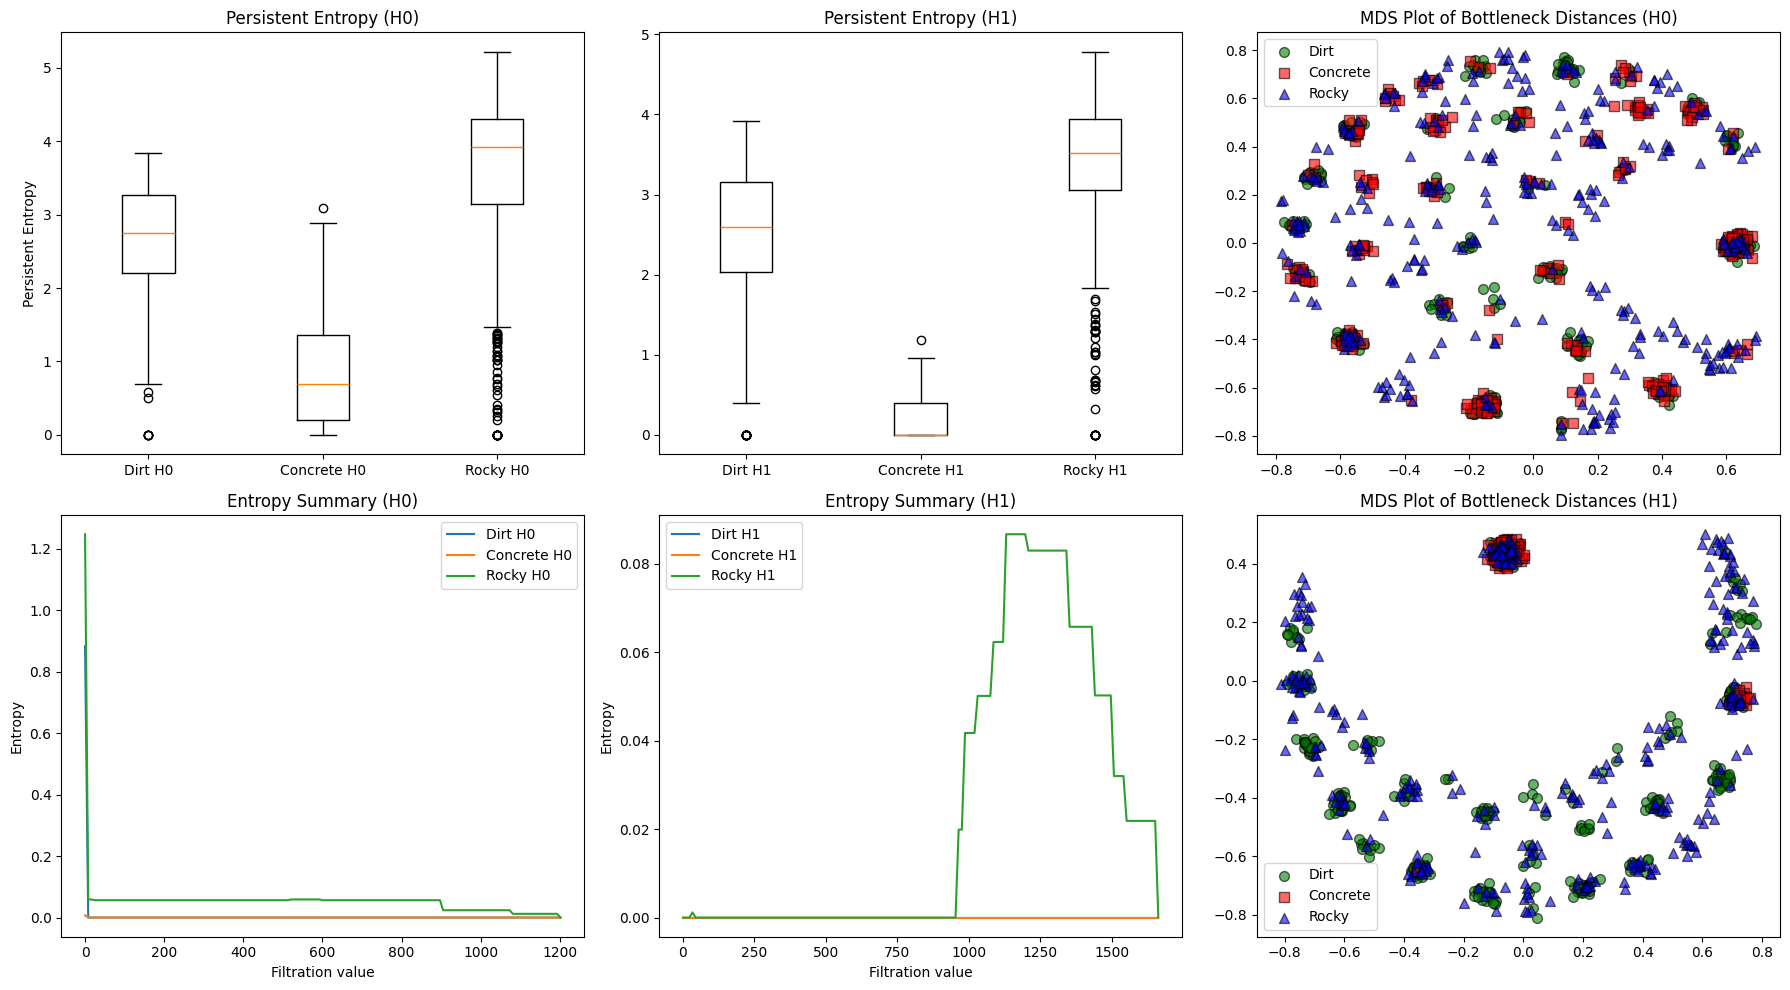

In [ ]:
import numpy as np
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt

remove_infinity = lambda barcode: np.array([bar for bar in barcode if bar[1] != np.inf])

dirt_diags_0_finite = list(map(remove_infinity, dirt_diags_0))
concrete_diags_0_finite = list(map(remove_infinity, concrete_diags_0))
rocky_diags_0_finite = list(map(remove_infinity, rocky_diags_0))

dirt_diags_1_finite = list(map(remove_infinity, dirt_diags_1))
concrete_diags_1_finite = list(map(remove_infinity, concrete_diags_1))
rocky_diags_1_finite = list(map(remove_infinity, rocky_diags_1))

def fix_diagram_shape(diagram):
    arr = np.array(diagram)
    if arr.size == 0:
        return arr.reshape(0, 2)
    if arr.ndim == 1:
        arr = arr.reshape(1, 2)
    return arr

dirt_diags_0_finite = [fix_diagram_shape(d) for d in dirt_diags_0_finite]
concrete_diags_0_finite = [fix_diagram_shape(d) for d in concrete_diags_0_finite]
rocky_diags_0_finite = [fix_diagram_shape(d) for d in rocky_diags_0_finite]

dirt_diags_1_finite = [fix_diagram_shape(d) for d in dirt_diags_1_finite]
concrete_diags_1_finite = [fix_diagram_shape(d) for d in concrete_diags_1_finite]
rocky_diags_1_finite = [fix_diagram_shape(d) for d in rocky_diags_1_finite]

def filter_nonempty(barcodes):
    return [b for b in barcodes if b.shape[0] > 0]

dirt_diags_0_finite = filter_nonempty(dirt_diags_0_finite)
concrete_diags_0_finite = filter_nonempty(concrete_diags_0_finite)
rocky_diags_0_finite = filter_nonempty(rocky_diags_0_finite)

dirt_diags_1_finite = filter_nonempty(dirt_diags_1_finite)
concrete_diags_1_finite = filter_nonempty(concrete_diags_1_finite)
rocky_diags_1_finite = filter_nonempty(rocky_diags_1_finite)

PE = gd.representations.Entropy()

pe_dirt_0 = PE.fit_transform(dirt_diags_0_finite)
pe_concrete_0 = PE.fit_transform(concrete_diags_0_finite)
pe_rocky_0 = PE.fit_transform(rocky_diags_0_finite)

pe_dirt_1 = PE.fit_transform(dirt_diags_1_finite)
pe_concrete_1 = PE.fit_transform(concrete_diags_1_finite)
pe_rocky_1 = PE.fit_transform(rocky_diags_1_finite)

num_dirt = len(pe_dirt_0)
num_concrete = len(pe_concrete_0)
num_rocky = len(pe_rocky_0)

max_death_0 = max(
    max(bar[1] for barcode in dirt_diags_0_finite for bar in barcode),
    max(bar[1] for barcode in concrete_diags_0_finite for bar in barcode),
    max(bar[1] for barcode in rocky_diags_0_finite for bar in barcode),
)

max_death_1 = max(
    max(bar[1] for barcode in dirt_diags_1_finite for bar in barcode),
    max(bar[1] for barcode in concrete_diags_1_finite for bar in barcode),
    max(bar[1] for barcode in rocky_diags_1_finite for bar in barcode),
)

ES0 = gd.representations.Entropy(
    mode='vector', sample_range=[0, max_death_0], resolution=151, normalized=False
)
ES1 = gd.representations.Entropy(
    mode='vector', sample_range=[0, max_death_1], resolution=151, normalized=False
)

es_dirt_0 = ES0.fit_transform(dirt_diags_0_finite)
es_concrete_0 = ES0.fit_transform(concrete_diags_0_finite)
es_rocky_0 = ES0.fit_transform(rocky_diags_0_finite)

es_dirt_1 = ES1.fit_transform(dirt_diags_1_finite)
es_concrete_1 = ES1.fit_transform(concrete_diags_1_finite)
es_rocky_1 = ES1.fit_transform(rocky_diags_1_finite)

x_vals_0 = np.linspace(0, max_death_0, 151)
x_vals = np.linspace(0, max_death_1, 151)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].boxplot([pe_dirt_0[:, 0], pe_concrete_0[:, 0], pe_rocky_0[:, 0]], labels=['Dirt H0', 'Concrete H0', 'Rocky H0'])
axs[0, 0].set_title('Persistent Entropy (H0)')
axs[0, 0].set_ylabel('Persistent Entropy')

axs[0, 1].boxplot([pe_dirt_1[:, 0], pe_concrete_1[:, 0], pe_rocky_1[:, 0]], labels=['Dirt H1', 'Concrete H1', 'Rocky H1'])
axs[0, 1].set_title('Persistent Entropy (H1)')

axs[0, 2].scatter(pos_h0_jittered[:num_dirt, 0], pos_h0_jittered[:num_dirt, 1], color='green', label='Dirt', alpha=0.6, edgecolors='k', s=50, marker='o')
axs[0, 2].scatter(pos_h0_jittered[num_dirt:num_dirt+num_concrete, 0], pos_h0_jittered[num_dirt:num_dirt+num_concrete, 1], color='red', label='Concrete', alpha=0.6, edgecolors='k', s=50, marker='s')
axs[0, 2].scatter(pos_h0_jittered[num_dirt+num_concrete:, 0], pos_h0_jittered[num_dirt+num_concrete:, 1], color='blue', label='Rocky', alpha=0.6, edgecolors='k', s=50, marker='^')
axs[0, 2].set_title('MDS Plot of Bottleneck Distances (H0)')
axs[0, 2].legend()

min_len_h0 = min(len(x_vals_0), es_dirt_0.shape[1])
axs[1, 0].plot(x_vals_0[:min_len_h0], np.mean(es_dirt_0, axis=0)[:min_len_h0], label='Dirt H0')
axs[1, 0].plot(x_vals_0[:min_len_h0], np.mean(es_concrete_0, axis=0)[:min_len_h0], label='Concrete H0')
axs[1, 0].plot(x_vals_0[:min_len_h0], np.mean(es_rocky_0, axis=0)[:min_len_h0], label='Rocky H0')
axs[1, 0].set_title('Entropy Summary (H0)')
axs[1, 0].set_xlabel('Filtration value')
axs[1, 0].set_ylabel('Entropy')
axs[1, 0].legend()

min_len_h1 = min(len(x_vals), es_dirt_1.shape[1])
axs[1, 1].plot(x_vals[:min_len_h1], np.mean(es_dirt_1, axis=0)[:min_len_h1], label='Dirt H1')
axs[1, 1].plot(x_vals[:min_len_h1], np.mean(es_concrete_1, axis=0)[:min_len_h1], label='Concrete H1')
axs[1, 1].plot(x_vals[:min_len_h1], np.mean(es_rocky_1, axis=0)[:min_len_h1], label='Rocky H1')
axs[1, 1].set_title('Entropy Summary (H1)')
axs[1, 1].set_xlabel('Filtration value')
axs[1, 1].set_ylabel('Entropy')
axs[1, 1].legend()

axs[1, 2].scatter(pos_h1_jittered[:num_dirt, 0], pos_h1_jittered[:num_dirt, 1], color='green', label='Dirt', alpha=0.6, edgecolors='k', s=50, marker='o')
axs[1, 2].scatter(pos_h1_jittered[num_dirt:num_dirt+num_concrete, 0], pos_h1_jittered[num_dirt:num_dirt+num_concrete, 1], color='red', label='Concrete', alpha=0.6, edgecolors='k', s=50, marker='s')
axs[1, 2].scatter(pos_h1_jittered[num_dirt+num_concrete:, 0], pos_h1_jittered[num_dirt+num_concrete:, 1], color='blue', label='Rocky', alpha=0.6, edgecolors='k', s=50, marker='^')
axs[1, 2].set_title('MDS Plot of Bottleneck Distances (H1)')
axs[1, 2].legend()

plt.tight_layout()
plt.show()
